In [1]:
!git clone "https://github.com/UCSD-AI4H/COVID-CT.git"

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5459, done.
remote: Total 5459 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5459/5459), 1.09 GiB | 42.30 MiB/s, done.
Resolving deltas: 100% (363/363), done.
Checking out files: 100% (1048/1048), done.


In [2]:
!pip install tensorflow-gpu
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import shutil
from glob import glob
# Helper libraries
import matplotlib.pyplot as plt
import math
%matplotlib inline
print(tf.__version__)

     |████████████████████████████████| 516.2MB 30kB/s 
2.2.0


In [5]:
cd COVID-CT/Images-processed/

/content/COVID-CT/Images-processed


In [7]:
!unzip -q CT_COVID.zip
!unzip -q CT_NonCOVID.zip

In [8]:
data_root='/content/COVID_CT/Images-Processed/'
path_positive_cases = os.path.join('/content/COVID-CT/Images-processed/CT_COVID/')
path_negative_cases = os.path.join('/content/COVID-CT/Images-processed/CT_NonCOVID/')

In [9]:
positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))
# positive_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))
negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))
negative_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))

In [10]:
total_positive_covid = len(positive_images_ls)
total_negative_covid = len(negative_images_ls)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 349
Total Negative Cases Covid19 images: 397


In [11]:
covid = {'class': 'CT_COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

non_covid = {'class': 'CT_NonCOVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

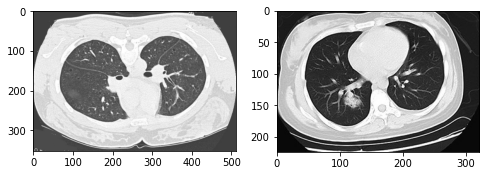

In [12]:
image_positive = cv2.imread(os.path.join(positive_images_ls[1]))
image_negative = cv2.imread(os.path.join(negative_images_ls[5]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)
f.add_subplot(1,2, 2)
plt.imshow(image_positive)

In [13]:
print("Image COVID Shape {}".format(image_positive.shape))
print("Image Non COVID Shape {}".format(image_negative.shape))

Image COVID Shape (224, 322, 3)
Image Non COVID Shape (353, 512, 3)


In [14]:
# Create Train-Test Directory
subdirs  = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['CT_COVID', 'CT_NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [15]:
random.seed(12)

In [16]:
test_ratio=0.1
for cases in [covid,non_covid]:
  total_cases = len(cases['images'])
  num_to_select = int(test_ratio*total_cases)
  print(cases['class']+str(num_to_select))
  list_of_random_files= random.sample(cases['images'],num_to_select)
  for files in list_of_random_files:
    shutil.copy2(files,'test/'+cases['class'])

CT_COVID34
CT_NonCOVID39


In [17]:
for cases in [covid,non_covid]:
  image_test_files = os.listdir('/content/COVID-CT/Images-processed/test/'+cases['class']+'/')
  for images in cases['images']:
    if images.split('/')[-1] not in (image_test_files):
      shutil.copy2(images,'train/'+cases['class'])

In [18]:
# cp -r "/content/drive/My Drive/data/test" "Images-processed/"


In [19]:
# cp -r "/content/drive/My Drive/data/train" "Images-processed/"

In [20]:
total_train_covid = len(os.listdir("/content/COVID-CT/Images-processed/train/CT_COVID/"))
total_train_noncovid = len(os.listdir("/content/COVID-CT/Images-processed/train/CT_NonCOVID/"))
total_test_covid = len(os.listdir("/content/COVID-CT/Images-processed/test/CT_COVID/"))
total_test_noncovid = len(os.listdir("/content/COVID-CT/Images-processed/test/CT_NonCOVID/"))
print(total_train_covid,total_train_noncovid,total_test_covid,total_test_noncovid)

315 358 34 39


In [21]:
train_dir = os.path.join('/content/COVID-CT/Images-processed/train/')
test_dir = os.path.join('/content/COVID-CT/Images-processed/test/')


total_train = total_train_covid + total_train_noncovid
total_test = total_test_covid + total_test_noncovid

In [22]:
import tensorflow.keras.applications as tfka

In [51]:
batch_size = 64
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150
num_classes=2

In [24]:
# model.layers[0].trainable=False

In [25]:
train_image_generator = ImageDataGenerator(rescale=1./255,) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255,) # Generator for our validation data

In [26]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 673 images belonging to 2 classes.


In [27]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 73 images belonging to 2 classes.


In [52]:
model = Sequential([
    tfka.DenseNet121(include_top=False,weights='imagenet',input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max',classes=2),
    Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
    Dropout(0.4),
    Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
    Dropout(0.3),
    Dense(num_classes,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(l=0.1))
])
model.layers[0].trainable=True

In [53]:
model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 7,694,146
Trainable params: 7,610,498
Non-trainable params: 83,648
_______________________________________

In [55]:
history = model.fit(train_data_gen, epochs=epochs, validation_data=test_data_gen)

Epoch 1/15
11/11 [==============================] - 5s 460ms/step - loss: 84.5585 - accuracy: 0.6419 - val_loss: 62.8989 - val_accuracy: 0.5890
Epoch 2/15
11/11 [==============================] - 4s 320ms/step - loss: 50.0551 - accuracy: 0.8009 - val_loss: 36.2131 - val_accuracy: 0.4658
Epoch 3/15
11/11 [==============================] - 3s 317ms/step - loss: 27.8278 - accuracy: 0.8276 - val_loss: 20.0063 - val_accuracy: 0.4932
Epoch 4/15
11/11 [==============================] - 3s 315ms/step - loss: 15.1808 - accuracy: 0.8663 - val_loss: 10.8034 - val_accuracy: 0.5616
Epoch 5/15
11/11 [==============================] - 3s 317ms/step - loss: 8.0640 - accuracy: 0.9004 - val_loss: 5.9354 - val_accuracy: 0.4795
Epoch 6/15
11/11 [==============================] - 4s 320ms/step - loss: 4.4764 - accuracy: 0.9227 - val_loss: 3.3042 - val_accuracy: 0.6575
Epoch 7/15
11/11 [==============================] - 4s 325ms/step - loss: 2.4873 - accuracy: 0.9554 - val_loss: 2.0350 - val_accuracy: 0.643

In [56]:
model.save('/content/saved_model/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/saved_model/assets


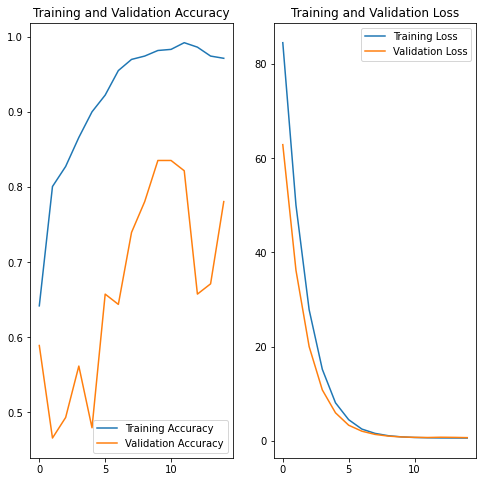

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()